# preparing Templates

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import numpy as np
import healpy as hp
import pandas as pd

In [2]:
dr = ft.read('/home/mehdi/data/templates/pixweight-dark.fits')
ix_ = hp.reorder(np.arange(dr.size), n2r=True)

columns = ['STARDENS', 'EBV', 
           'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 
           'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 
           'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z',           
           'PSFDEPTH_W1', 'PSFDEPTH_W2']

# http://legacysurvey.org/dr8/files/#random-catalogs
FluxToMag = lambda flux: -2.5 * (np.log10(5/np.sqrt(flux)) - 9.)

# http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
ext = dict(g=3.214, r=2.165, z=1.211)

tmpl = {}
for col in columns:
    col_name = col.lower()
    col_val = dr[col][ix_].byteswap().newbyteorder()
    
    if 'depth' in col_name:
        band = col_name.split('_')[-1]
        
        col_val = FluxToMag(col_val) 
        if band in 'rgz':
            col_val -= ext[band]*tmpl['ebv']
        print(col_name, band)
        
    tmpl[col_name] = col_val
    
tmpl2 = pd.read_hdf('/home/mehdi/data/templates/dr9/dr9m_nside256.h5')

columns2 = ['loghi']\
          +[f'{s}_{b}' for s in ['ccdskymag_mean', 'fwhm_mean', 'fwhm_min', 'fwhm_max', 'depth_total', 
                                'mjd_mean', 'mjd_min', 'mjd_max', 'airmass_mean', 'exptime_total']\
                      for b in ['g', 'r', 'z']]

for col in columns2:
    tmpl[col] = tmpl2[col].values   
    
tmpl = pd.DataFrame(tmpl)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


psfdepth_g g
psfdepth_r r
psfdepth_z z
galdepth_g g
galdepth_r r
galdepth_z z
psfdepth_w1 w1
psfdepth_w2 w2


In [3]:
tmpl['lognstar'] = np.log10(1.+tmpl['stardens'])
tmpl = tmpl.replace([-1, np.inf, -np.inf], np.nan)

In [4]:
is_good = tmpl.isna().values.sum(axis=1) < 1

In [5]:
for col in tmpl:
    print(f'{col:20s}, {np.percentile(tmpl[col][is_good], [0, 1, 99, 100])}')

stardens            , [   76.2545929    247.8274231   3126.43823242 16547.24804688]
ebv                 , [0.00143164 0.00805812 0.15892798 0.86603606]
psfdepth_g          , [21.27593422 23.86438564 25.37751175 25.63746262]
psfdepth_r          , [21.26277924 23.35048195 25.17856865 25.49821091]
psfdepth_z          , [20.34397507 22.67303364 24.01061028 24.28423882]
galdepth_g          , [21.19980621 23.66368507 25.09977909 25.34727287]
galdepth_r          , [21.14349365 23.15285816 24.83891911 25.13072777]
galdepth_z          , [20.17395973 22.33447796 23.62110939 23.9338398 ]
psfsize_g           , [0.11757471 1.20558595 2.33367376 3.3285985 ]
psfsize_r           , [0.10427068 1.08609066 2.14822731 3.15092444]
psfsize_z           , [0.08735849 0.97600286 1.77605068 2.69280601]
psfdepth_w1         , [20.61217308 21.25683594 21.88623848 22.22574615]
psfdepth_w2         , [20.31412506 20.59452057 21.43469677 22.15116119]
loghi               , [19.6889075  19.91203252 20.97403779 21.266641

In [6]:
tmpl.to_hdf('/home/mehdi/data/templates/dr9/pixweight_dark_dr9m_nside256.h5', 'templates')

In [7]:
tmpl.columns

Index(['stardens', 'ebv', 'psfdepth_g', 'psfdepth_r', 'psfdepth_z',
       'galdepth_g', 'galdepth_r', 'galdepth_z', 'psfsize_g', 'psfsize_r',
       'psfsize_z', 'psfdepth_w1', 'psfdepth_w2', 'loghi', 'ccdskymag_mean_g',
       'ccdskymag_mean_r', 'ccdskymag_mean_z', 'fwhm_mean_g', 'fwhm_mean_r',
       'fwhm_mean_z', 'fwhm_min_g', 'fwhm_min_r', 'fwhm_min_z', 'fwhm_max_g',
       'fwhm_max_r', 'fwhm_max_z', 'depth_total_g', 'depth_total_r',
       'depth_total_z', 'mjd_mean_g', 'mjd_mean_r', 'mjd_mean_z', 'mjd_min_g',
       'mjd_min_r', 'mjd_min_z', 'mjd_max_g', 'mjd_max_r', 'mjd_max_z',
       'airmass_mean_g', 'airmass_mean_r', 'airmass_mean_z', 'exptime_total_g',
       'exptime_total_r', 'exptime_total_z', 'lognstar'],
      dtype='object')

In [2]:
dcat = ft.read('/home/mehdi/data/sv3/sv3target_LRG_SDECALS.fits', columns=['RA', 'DEC'])

In [3]:
ndecals = ft.read('/home/mehdi/data/sv3/sv3target_LRG_NDECALS.fits', columns=['RA', 'DEC'])

In [4]:
bmzls = ft.read('/home/mehdi/data/sv3/sv3target_LRG_NBMZLS.fits', columns=['RA', 'DEC'])

In [7]:
import numpy as np

In [10]:
def shift(ra):
    return ra-360*(ra>300)

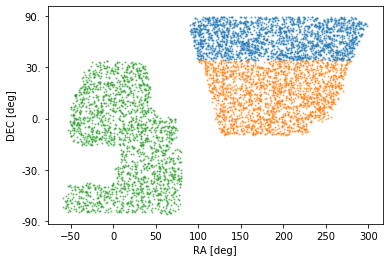

In [21]:
for sample in [bmzls, ndecals, dcat]:
    ix = np.random.choice(np.arange(sample.size), size=2000, replace=False)
    plt.scatter(shift(sample['RA'][ix]), np.sin(np.pi*sample['DEC'][ix]/180.), 5, marker='.', alpha=0.5)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
_ = plt.yticks(ticks=[-1.0, -0.5, 0.0, 0.5, 1.0], labels=['-90.', '-30.', '0.', '30.', '90.'])

In [1]:
# LRGs
import sys
sys.path.append('/home/mehdi/github/LSSutils')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp

import numpy as np
import fitsio as ft

from lssutils.lab import (make_overdensity, AnaFast, 
                          histogram_cell, NNWeight, hpixsum, get_meandensity,
                          get_meandensity)
from lssutils.stats.pcc import pcc
from lssutils.dataviz import setup_color
import pandas as pd

In [2]:
setup_color()

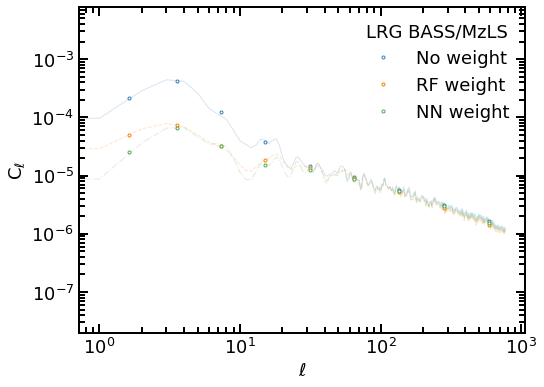

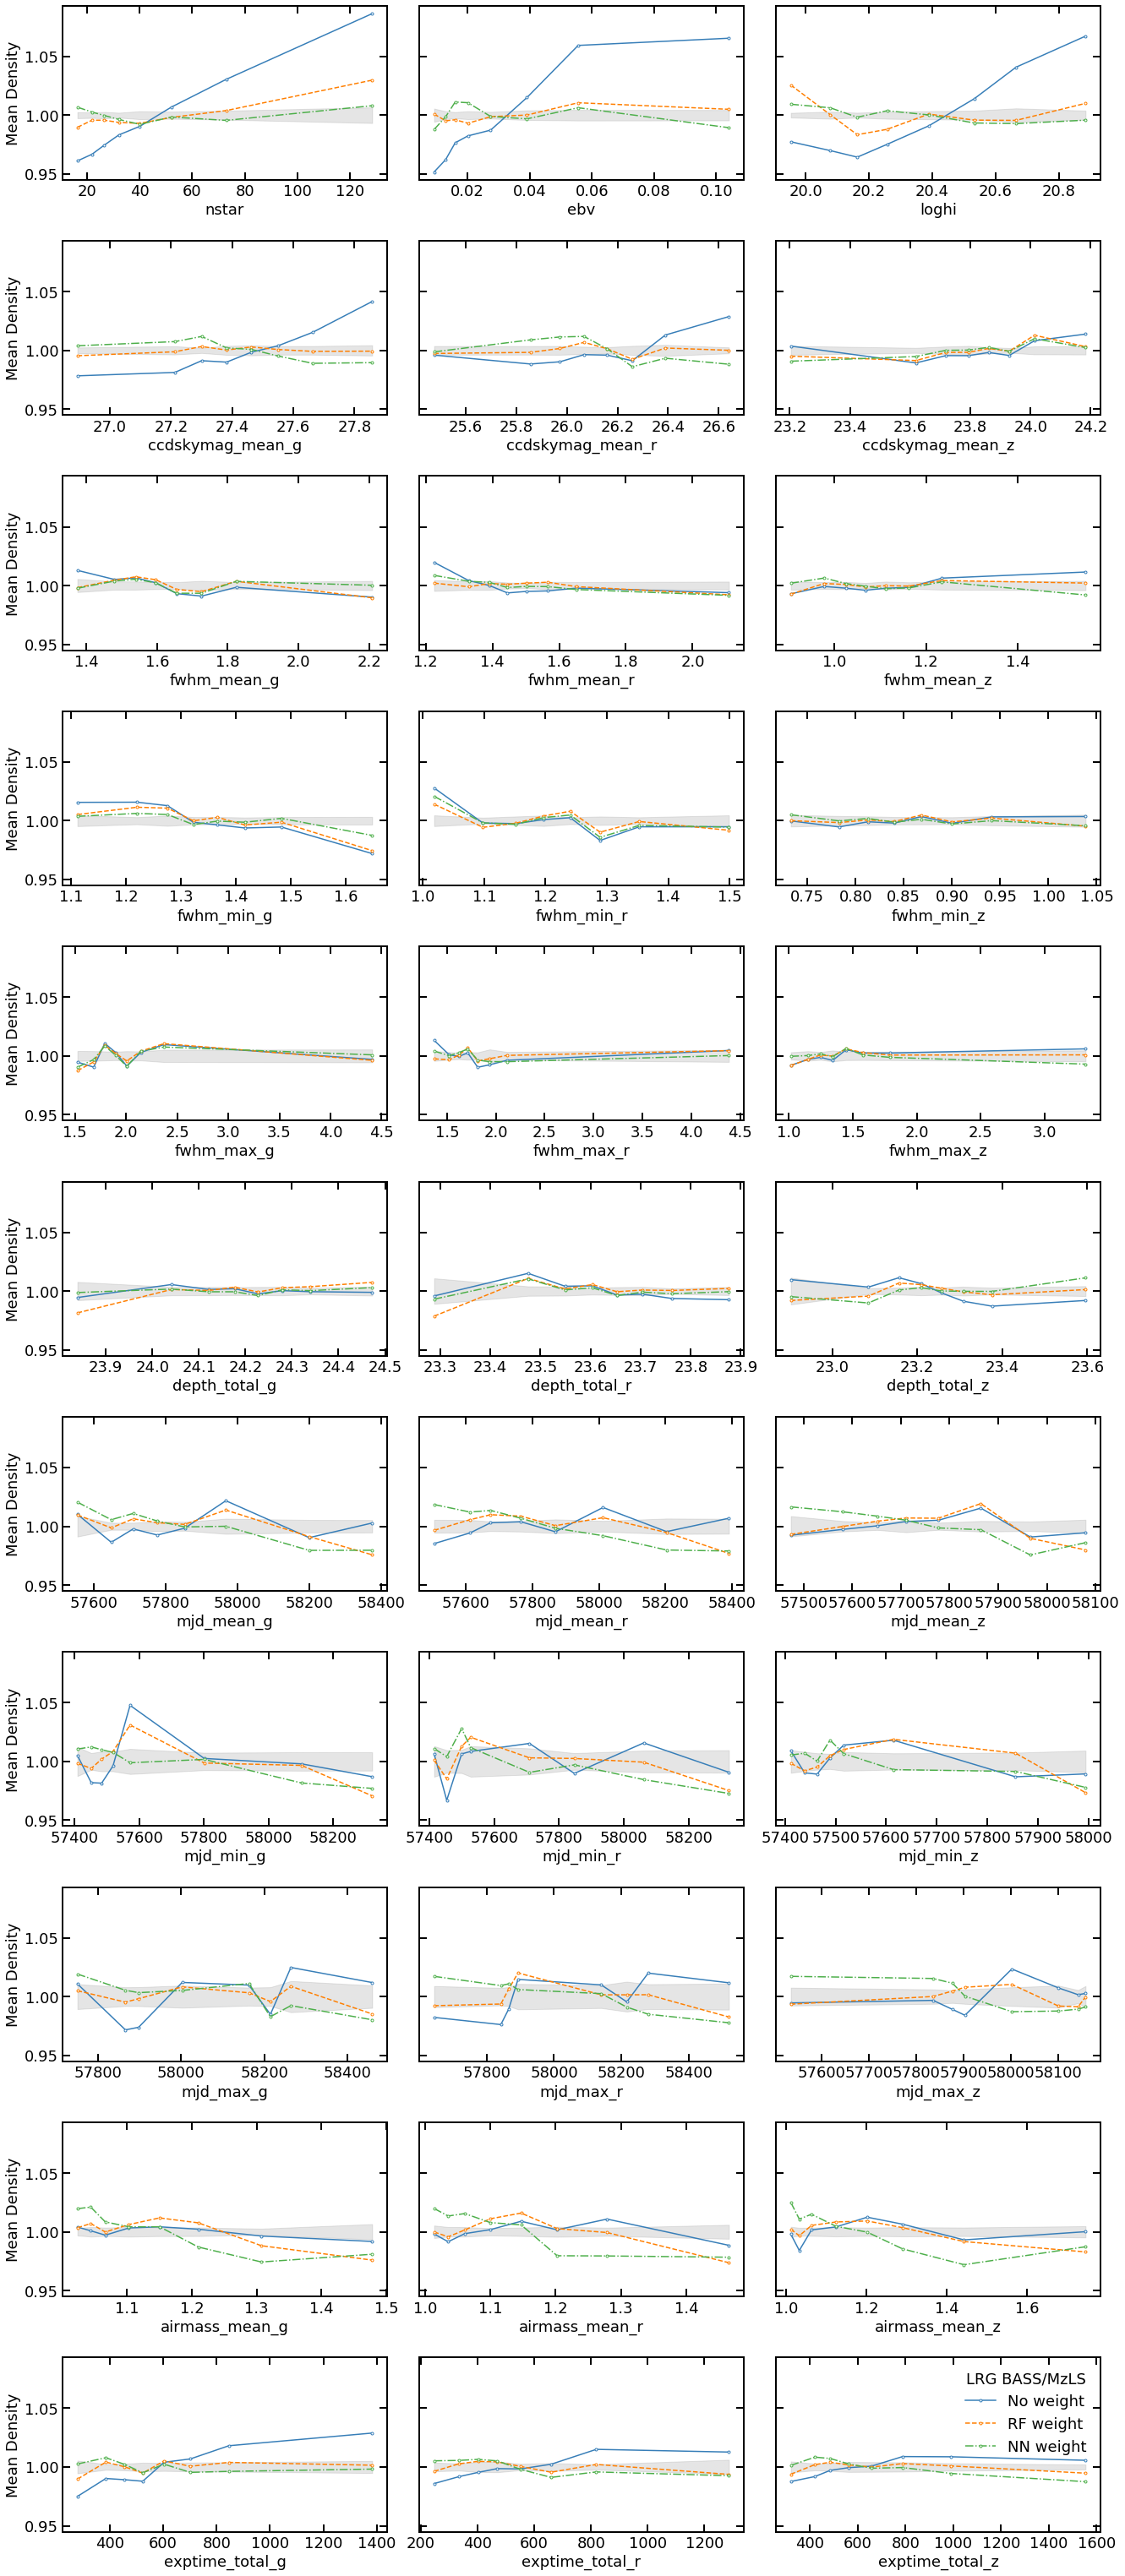

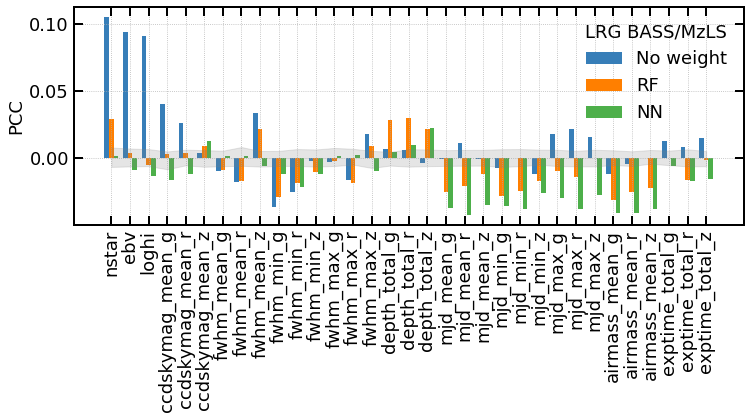

In [11]:
pp = PdfPages('lrg_bass.pdf')



methods = ['No weight', 'RF weight', 'NN weight']
cls = [sv.cl_now, sv.cl_rf, sv.cl_nn]


fg, ax = plt.subplots(figsize=(8, 6))

# C_ell
for n_i, cl_i in zip(methods, cls ):

    lb, clb = histogram_cell(cl_i['cl'], bins=np.logspace(0, np.log10(770), 10))
    
    l_, = ax.plot(cl_i['cl'], lw=1, zorder=-1, alpha=0.2)
    ax.plot(lb, clb, marker='.', mfc='w', ls='None', color=l_.get_color(), label=n_i)
    
ax.legend(title='LRG BASS/MzLS', frameon=False)
ax.set(xscale='log', yscale='log', ylim=(2.0e-8, 8.0e-3), 
       xlabel=r'$\ell$', ylabel=r'C$_{\ell}$')

#fg.savefig('cl_lrg_bmzls.png', dpi=300, bbox_inches='tight')
pp.savefig(bbox_inches='tight')


# Nbar
fig, ax = plt.subplots(ncols=3, nrows=11, figsize=(22, 55), sharey=True)
fig.subplots_adjust(hspace=0.35, wspace=0.1)
ax = ax.flatten()


nbars = [sv.nbar_now, sv.nbar_rf, sv.nbar_nn]
for name_i, nbar_i in zip(methods, nbars):
    
    for j, nbar_ij in enumerate(nbar_i):
        ax[j].plot(nbar_ij['bin_avg'], nbar_ij['nnbar'], marker='.', mfc='w', label=name_i)
        
        if name_i == 'No weight':
            ax[j].fill_between(nbar_ij['bin_avg'], 1-nbar_ij['nnbar_err'], 1+nbar_ij['nnbar_err'],
                              color='grey', alpha=0.2, zorder=-1)
                          
ax[-1].legend(title='LRG BASS/MzLS', frameon=False)
for j, axj in enumerate(ax):
    axj.set_xlabel(sv.cols[j])
    if j%3==0:
        axj.set_ylabel('Mean Density')
        
pp.savefig(bbox_inches='tight')
# plt.savefig('nbar_lrg_bmzls.png', dpi=300, bbox_inches='tight')

# PCC
fg, ax = plt.subplots(figsize=(12, 4))
x_columns = np.arange(len(sv.cols))
ax.set_xticks(x_columns)
ax.set_xticklabels(sv.cols, rotation=90)

pcc_min, pcc_max = np.percentile(sv.pcc_now[1], [2.5, 97.5], axis=0)

ax.bar(x_columns-0.25, sv.pcc_now[0], width=0.25, label='No weight')
ax.bar(x_columns,      sv.pcc_rf[0],  width=0.25, label='RF')
ax.bar(x_columns+0.25, sv.pcc_nn[0], width=0.25, label='NN')
ax.fill_between(x_columns, pcc_min, pcc_max, color='grey', alpha=0.2, zorder=10)
ax.legend(title='LRG BASS/MzLS', frameon=False)
ax.grid(ls=':')
ax.set(ylabel='PCC')
pp.savefig(bbox_inches='tight')

pp.close()